In [1]:
import os

import numpy as np
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["font.family"] = "Arial"

from src.analysis import neurostim
from src.analysis import util

%load_ext autoreload
%autoreload 2

In [2]:
root = os.path.expanduser("~/PycharmProjects/SpikeToExcite")
data_root = "/home/datasets/natural"  # Set the path of the natural dataset
model_id = "prediction_0.0017782794100389228_0.3_0.1_0_17_0.2_0.5"

In [3]:
firing_rate_neurostim_analysis = neurostim.NeuroStimAnalysis(root, model_id, metric="firing_rate")
frac_seizures_neurostim_analysis = neurostim.NeuroStimAnalysis(root, model_id, metric="frac_seizures")
pred_mse_neurostim_analysis = neurostim.NeuroStimAnalysis(root, model_id, metric="pred_mse")

In [4]:
i, j = -31, 20
control_model_spikes, control_model_mse, subspatialclip, control_model_output = firing_rate_neurostim_analysis.stimulator.get_raster("control", flash_hz=100, amp=0, i=i, j=j)
seizure_model_spikes, seizure_model_mse, subspatialclip, seizure_model_output = firing_rate_neurostim_analysis.stimulator.get_raster("seizure", flash_hz=100, amp=0, i=i, j=j)
seizurestim_model_spikes, seizurestim_model_mse, subspatialclip, seizurestim_model_output = firing_rate_neurostim_analysis.stimulator.get_raster("seizure", flash_hz=120, amp=-0.04, i=i, j=j)

## Qualitative stimulatory results

In [5]:
def plot_raster(spikes, title, color, s=0.001, alpha=0.5, fig_spec=None):
    ax = plt.subplot(fig_spec)
    x, y = util.spike_tensor_to_points(spikes[0])
    ax.scatter(x, y, s=s, alpha=alpha, c=color)
    ax.set_ylim([0, 600])
    ax.set_yticks([0, 600])
    ax.set_xlim([0, spikes.shape[-1]])
    ax.set_xticklabels([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.xaxis.set_tick_params(width=3, labelsize=14, pad=8)
    ax.yaxis.set_tick_params(width=3, labelsize=14, pad=8)
    ax.set_xlabel(None)
    ax.set_ylabel("Unit", fontsize=14, labelpad=4)
    ax.set_title(title, fontsize=14, pad=20, color=color)

    return ax

Text(0.5, 0, 'Time')

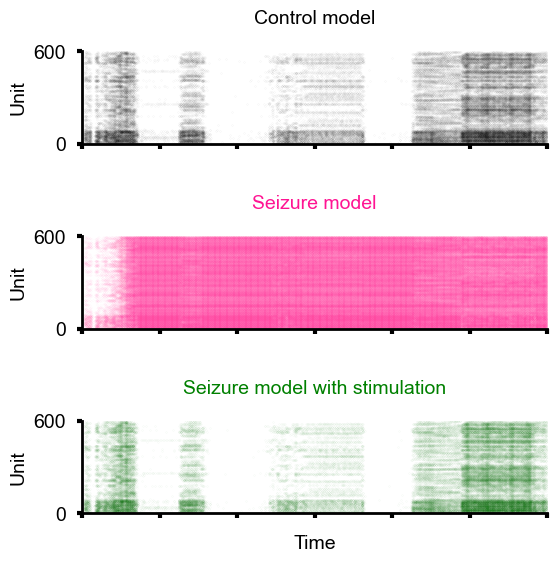

In [6]:
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(3, 1, wspace=0., hspace=1)

plot_raster(control_model_spikes, "Control model", "black", fig_spec=fig_spec[0])
plot_raster(seizure_model_spikes, "Seizure model", "deeppink", alpha=0.3, fig_spec=fig_spec[1])
ax = plot_raster(seizurestim_model_spikes, "Seizure model with stimulation", "green", fig_spec=fig_spec[2])
ax.set_xlabel("Time", fontsize=14, labelpad=4)
# plt.savefig(f"{root}/figures/fig6/rasters.svg", format="svg", transparent=False, bbox_inches="tight")

## Quantitative stimulatory results

In [7]:
def plot_metric2D(metric_df, metric, cmap, log, fig_spec):
    ax = plt.subplot(fig_spec)
    values = metric_df if not log else np.log10(metric_df)
    vmin, vmax = values.values.min(), values.values.max()
    values = (values - vmin) / (vmax - vmin)
    c = ax.pcolormesh([str(s) for s in metric_df.columns], [str(s) for s in metric_df.index], values, shading='auto', cmap=cmap, vmin=0, vmax=1)
    cb = fig.colorbar(c, ax=ax, label=metric)
    cb.set_ticks([0, 1])  # Set the desired min and max ticks
    vmin = 100 * vmin if not log else vmin
    vmax = 100 * vmax if not log else vmax
    cb.ax.set_yticklabels([f"{vmin:.2f}", f"{vmax:.2f}"], size=20)  # Set the d
    cb.set_label(metric, fontsize=20)
    ax.set_ylabel("Pulse amp. (a.u.)", fontsize=20, labelpad=6)
    ax.yaxis.set_tick_params(width=3, labelsize=20, pad=6)
    ax.xaxis.set_tick_params(width=3, labelsize=20, pad=6)
    ax.set_xticklabels([])
    #ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha="right")
    # ["0.0", "", "-0.02", "", "-0.08", "", "-0.32", "", "-1.28"]
    ax.set_yticklabels(["-1.28", "", "-0.32", "", "-0.08", "", "-0.02", "", "0.0"])
    
    return ax

/tmp/ipykernel_3841345/2521841517.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["-1.28", "", "-0.32", "", "-0.08", "", "-0.02", "", "0.0"])
/tmp/ipykernel_3841345/2521841517.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["-1.28", "", "-0.32", "", "-0.08", "", "-0.02", "", "0.0"])
/tmp/ipykernel_3841345/2521841517.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["-1.28", "", "-0.32", "", "-0.08", "", "-0.02", "", "0.0"])
/tmp/ipykernel_3841345/825694310.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "2", "", "8", "", "32", "", "120"])


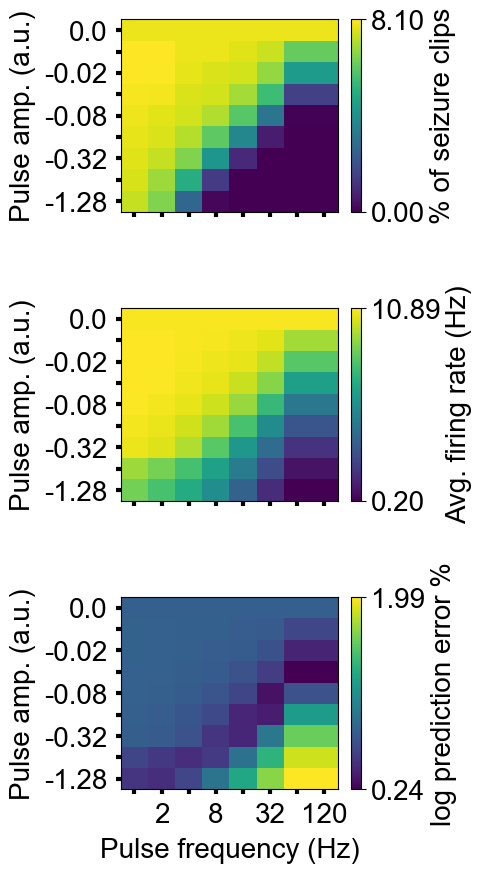

In [8]:
fig = plt.figure(figsize=(3.5, 10))
fig_spec = gridspec.GridSpec(3, 1, wspace=0., hspace=0.5)

metric_df = frac_seizures_neurostim_analysis.metric_df.pivot_table(index='amp', columns='flash_hz', values='value')
plot_metric2D(metric_df, "% of seizure clips", "viridis", log=False, fig_spec=fig_spec[0])

metric_df = firing_rate_neurostim_analysis.metric_df.pivot_table(index='amp', columns='flash_hz', values='value')
plot_metric2D(metric_df, "Avg. firing rate (Hz)", "viridis", log=False, fig_spec=fig_spec[1])

metric_df = pred_mse_neurostim_analysis.metric_df.pivot_table(index='amp', columns='flash_hz', values='value')
ax = plot_metric2D(metric_df, "log prediction error %", "viridis", log=True, fig_spec=fig_spec[2])

ax.set_xlabel("Pulse frequency (Hz)", fontsize=20, labelpad=6)
# ax.set_xticklabels(["1", "2", "4", "8", "16", "32", "64", "120"], rotation=45, ha="right")
ax.set_xticklabels(["", "2", "", "8", "", "32", "", "120"])
plt.savefig(f"{root}/figures/fig6/quant.svg", format="svg", transparent=False, bbox_inches="tight")

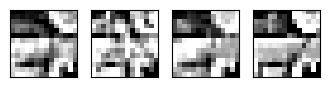

In [9]:
def plot_frame(frame, ax):
    ax.imshow(frame, vmin=-1, vmax=1, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

fig, ax = plt.subplots(1, 4, figsize=(4, 6))

frame_idx = 875-30+22
plot_frame(control_model_output[0, 0, frame_idx][3:-3, 3:-3], ax[0])
plot_frame(seizure_model_output[0, 0, frame_idx][3:-3, 3:-3], ax[1])
plot_frame(seizurestim_model_output[0, 0, frame_idx][3:-3, 3:-3], ax[2])
plot_frame(subspatialclip[0, 0, frame_idx][3:-3, 3:-3], ax[3])
plt.savefig(f"{root}/figures/fig6/frames.svg", format="svg", transparent=False, bbox_inches="tight")

In [10]:
print(f"Firing rates (Hz)")
print(f"Control model = {120*control_model_spikes[0].mean():.2f}")
print(f"Seizure model = {120*seizure_model_spikes[0].mean():.2f}")
print(f"Seizure model with stim = {120*seizurestim_model_spikes[0].mean():.2f}")
print()
print(f"Predion errors (MSE)")
print(f"Control model = {control_model_mse:.2f}")
print(f"Seizure model = {seizure_model_mse:.2f}")
print(f"Seizure model with stim = {seizurestim_model_mse:.2f}")

Firing rates (Hz)
Control model = 10.01
Seizure model = 88.27
Seizure model with stim = 10.16

Predion errors (MSE)
Control model = 0.63
Seizure model = 0.92
Seizure model with stim = 0.63
